In [1]:
from elpv.utils.elpv_reader import load_dataset
import numpy as np
import matplotlib as plt
import cv2
import os

# scikit-learn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# tensorflow imports
import tensorflow
from tensorflow import keras
from keras.applications import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras import Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import layers

# from PIL import Image
import matplotlib.pyplot as plt

In [2]:
images, probs, types = load_dataset()
print(images.shape)
print(probs.shape)
print(types.shape)

(2624, 300, 300)
(2624,)
(2624,)


In [3]:
# OTSU IMAGE SEGMENTATION HUEHUEHUE
# uncomment below code for otsu segmentation
# for i in range(0, len(images)):
#     retOtsu,thOtsu = cv2.threshold(images[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     images[i] = thOtsu

# kernelLaplacian = np.array([[1, 1, 1],
#                             [1, -8, 1],
#                             [1, 1, 1]])

# for i in range(0, len(images)):
#     norm_img = cv2.normalize(images[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#     norm_img = (255*norm_img).astype(np.uint8)
#     images[i] = norm_img
#     # edging = cv2.filter2D(src=norm_img, ddepth=-1, kernel=kernelLaplacian)
#     # images[i] = edging


def isPoly(formatted_monopoly_data):
    res = np.zeros(len(formatted_monopoly_data))
    for i in range(0, len(formatted_monopoly_data)):
        res[i] = int(formatted_monopoly_data[i][1])
    
    return res

def getArgMax(probabilities):
    res = np.zeros(len(probabilities))
    for i in range(0, len(probabilities)):
        res[i] = np.argmax(probabilities[i])

    return res


In [4]:
# MAKE BIG TRAINING AND TESTING SET
images_3 = np.dstack([images] * 3)
images_3 = np.reshape(images_3, (-1, 300, 300, 3))

probs_formatted = probs
probs_label_encoder = LabelEncoder()
probs_integer = probs_label_encoder.fit_transform(probs_formatted)

probs_formatted = keras.utils.to_categorical(probs_integer)

types_formatted = types
types_label_encoder = LabelEncoder()
types_formatted = types_label_encoder.fit_transform(types_formatted)
types_formatted = keras.utils.to_categorical(types_formatted)

images_3_mono = images_3[types == "mono"]
images_3_poly = images_3[types == "poly"]
probs_formatted_mono = probs_formatted[types == "mono"]
probs_formatted_poly = probs_formatted[types == "poly"]

# Format "types_formatted" into "types_formatted | probs" for splitting data
types_probs_formatted = np.zeros((len(types_formatted), len(types_formatted[0]) + len(probs_formatted[0])))
for i in range (0, len(types_probs_formatted)):
    # types_probs_formatted[i] = np.concatenate(types_formatted[i], probs_formatted[i])
    types_probs_formatted[i, 0:len(types_formatted[0]):1] = types_formatted[i]
    types_probs_formatted[i, len(types_formatted[0]):len(types_probs_formatted[0]):1] = probs_formatted[i]


# training and testing data for types and final classifiers:
#   split types into test and train
#   x_train, test
#   y_mp_train, test
#   y_probs_train, test
x_train, x_test, y_combo_train, y_combo_test = train_test_split(images_3, types_probs_formatted, test_size=0.25, random_state=690)

y_mp_train = y_combo_train[:, 0:2]
y_train = y_combo_train[:, 2:6]

y_mp_test = y_combo_test[:, 0:2]
y_test = y_combo_test[:, 2:6]

In [5]:
# do the same with VGG, but for mono and poly images
vgg19_base = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
vgg19_base.trainable = False

vgg19_model = keras.models.Sequential([
  vgg19_base,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Flatten(input_shape=vgg19_base.output_shape[1:]),
  keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(len(np.unique(probs)), activation='softmax')
])

vgg19_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)

history_mono = vgg19_model.fit(x_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es], batch_size=200)

# PATH = 'models/vgg19_all_model.keras'
# vgg19_model.save(PATH)

Epoch 1/10
8/8 [==============================] - 201s 26s/step - loss: 54.6168 - accuracy: 0.3596 - val_loss: 12.3790 - val_accuracy: 0.6574
Epoch 2/10
8/8 [==============================] - 204s 26s/step - loss: 9.7981 - accuracy: 0.6544 - val_loss: 6.4712 - val_accuracy: 0.6929
Epoch 3/10
8/8 [==============================] - 201s 26s/step - loss: 3.2944 - accuracy: 0.6366 - val_loss: 2.3709 - val_accuracy: 0.2487
Epoch 4/10
8/8 [==============================] - 204s 26s/step - loss: 1.3753 - accuracy: 0.5915 - val_loss: 1.5212 - val_accuracy: 0.7081
Epoch 5/10
8/8 [==============================] - 187s 24s/step - loss: 1.0012 - accuracy: 0.7192 - val_loss: 1.0250 - val_accuracy: 0.6117
Epoch 6/10
8/8 [==============================] - 150s 19s/step - loss: 0.7757 - accuracy: 0.6881 - val_loss: 0.8005 - val_accuracy: 0.7157
Epoch 7/10
8/8 [==============================] - 147s 19s/step - loss: 0.6773 - accuracy: 0.7490 - val_loss: 0.7186 - val_accuracy: 0.7234
Epoch 8/10
8/8 [==

In [20]:
# score = vgg19_model.evaluate(x_test, y_test)
result = vgg19_model.predict(x_test)
# print(dict(zip(vgg19_model.metrics_names, score)))
# print(vgg19_model.metrics_names)

def getArgMax(probabilities):
    res = np.zeros(len(probabilities))
    for i in range(0, len(probabilities)):
        res[i] = np.argmax(probabilities[i])

    return res


predicted_int = getArgMax(result)
y_test_int = getArgMax(y_test)

from sklearn.metrics import classification_report
print(classification_report(predicted_int, y_test_int))

21/21 [==============================] - 48s 2s/step
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82       523
         1.0       0.14      0.65      0.23        17
         2.0       0.00      0.00      0.00         1
         3.0       0.59      0.87      0.70       115

    accuracy                           0.74       656
   macro avg       0.43      0.56      0.44       656
weighted avg       0.89      0.74      0.79       656



Mono Results     |  Accuracy: 0.75182  Precision: 0.53262  Recall: 0.46308  F1: 0.47233
Poly Results     |  Accuracy: 0.72513  Precision: 0.80695  Recall: 0.40042  F1: 0.4122
Combined Results |  Accuracy: 0.73628  Precision: 0.55698  Recall: 0.42553  F1: 0.43789


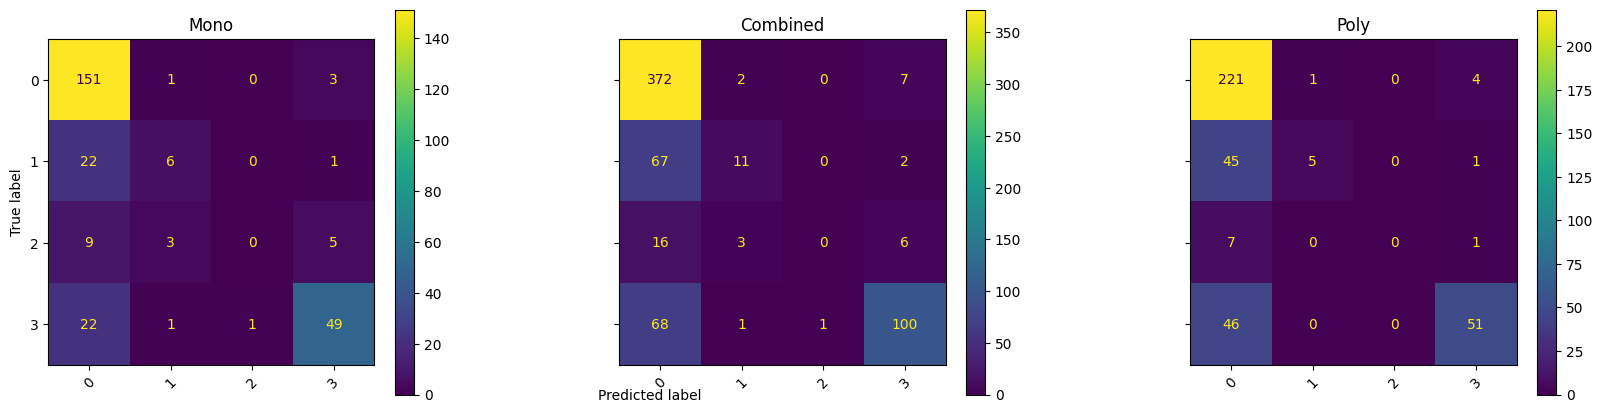

: 

In [21]:
import performancetest as pt
a = isPoly(y_mp_test) == 1
b = isPoly(y_mp_test) == 0
y_true_m = y_test_int[isPoly(y_mp_test) == 0]
y_true_p = y_test_int[isPoly(y_mp_test) == 1]
y_predict_m = predicted_int[isPoly(y_mp_test) == 0]
y_predict_p = predicted_int[isPoly(y_mp_test) == 1]

pt.display_results(y_true_m, y_true_p, y_predict_m, y_predict_p)